<a href="https://colab.research.google.com/github/mezaga/ACIML/blob/aciml-06%2F10%2F22/ACIML_seminario_prototype_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ACIML Prototipo**

Gerardo Meza, UNAM





---

DESCARGA DE AUDIOS:
https://drive.google.com/file/d/1KW_QrFYsts3ccMv222hJsOLWHKCPdCb_/view?usp=sharing


In [ ]:
#@title Carga de Librerias
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO" -O encoder2_cdmx.zip && rm -rf /tmp/cookies.txt
!unzip /content/encoder2_cdmx.zip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=169SFhtDzPuoM0d5YzIdRVjx3C-8dSB7o' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=169SFhtDzPuoM0d5YzIdRVjx3C-8dSB7o" -O decoder2_cdmx.zip && rm -rf /tmp/cookies.txt
!unzip /content/decoder2_cdmx.zip

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1egipBGfxnvWiDE4C0wgr2uO2-xfK3t3R' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1egipBGfxnvWiDE4C0wgr2uO2-xfK3t3R" -O vanilla_encoder.zip && rm -rf /tmp/cookies.txt
!unzip /content/vanilla_encoder.zip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12XmcSvVEsn3Fdg-SoCGxQGZdKQTSHeDU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12XmcSvVEsn3Fdg-SoCGxQGZdKQTSHeDU" -O vanilla_decoder.zip && rm -rf /tmp/cookies.txt
!unzip /content/vanilla_decoder.zip

from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import IPython
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import pickle
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import random
AUDIO_LOAD = []
etiquetas = []
track_num = []

# En la siguente celda puedes subir tus archivos.
1. Escoge el nombre del grupo de audios.
2. Evalúa la celda.
3. Repite hasta tener todos los conjuntos que necesites

In [ ]:
#@title Carga de archivos
## 

from google.colab import files
#@ tectInserta
text = 'fm' #@param {type:"string"}
#AUDIO_LOAD = []
sr16k = 16000
secs = 1
uploaded = files.upload()
#track_num.append(len(uploaded))
for idx, track in enumerate(uploaded.keys()):
  print(track)
  if track.endswith("wav"):
      SR = librosa.get_samplerate(track)
      y, fs = librosa.load(track, SR)
      data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
      ##features (tenemos que arreglar el fft apara que sean valores de amp)
      fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
      f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    #takes only 1 sec and resample to 16k 
      etiquetas.append(text)
      AUDIO_LOAD.append({'gid': text,'id': text+ str(idx), 'trackname': track, 'data': data, 'fft': fft, 'f0': f0})
      

En la siguiente celda podrás visualizar una tabla con múltiples características que los describen.

In [ ]:
#@title DATASET

DATA = pd.DataFrame(AUDIO_LOAD)
#PCA 
data_fft = np.vstack(DATA['fft'])
mu_fft = np.mean(data_fft, axis= 0)
s_fft = np.std(data_fft, axis = 0)+ 0.000001
Xmu_FFT = data_fft- mu_fft/s_fft
DATA

In [ ]:
#@title Filtrado
zliders = dict(DATA['gid'].value_counts())
color = list(np.random.choice(np.random.randint(0,30),len(zliders),replace = False))
sliders = []
for key in zliders.keys():
  sliders.append(widgets.IntSlider(value = zliders[key], max= zliders[key], step = 1, description= key))

update_sliders = dict(zip([x for x in zliders], sliders))

ui = widgets.VBox(sliders)

def datafilter(**kwargs):
  '''update n number of sliders corresponding to dataclases by splitting dataset uin subgroups and joining them again'''
  dframes = []
  for key, value in kwargs.items():
    dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value])
    #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
  print(DATA_filt['gid'])
  return DATA_filt


out = widgets.interactive_output(datafilter, update_sliders)
updated_df = datafilter
display(ui,out)

In [ ]:
#@title DATASET
dframes = []
for key, value in update_sliders.items():
  dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value.value])
  #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
audiotracks = dict(zip(DATA_filt['id'],DATA_filt['id'].index))
DATA_filt

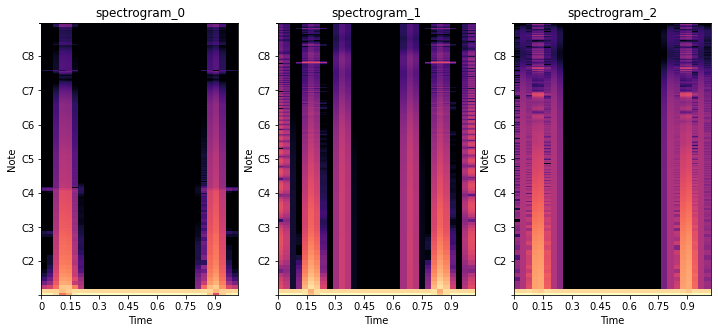

In [109]:
#@title Visualización de datos { run: "auto" }
ids = list(DATA_filt['id'])
audio_viz = 'spectrogram' #@param ['PCA','F0', 'histogram','spectrogram']
#fig, ax = plt.subplots()
plt.figure(figsize = [12,5])
#fig.set_size_inches([12,5])

if audio_viz == 'histogram':
  ax = plt.subplot(1,1,1)
  ax = DATA_filt['gid'].hist()
  ax.set_xlabel("Synth type")
  ax.set_ylabel(" # of observations")
  plt.show()
if audio_viz == 'F0':
  ax = plt.subplot(1,1,1)
  ax.set_xlabel("Audios")
  ax.set_ylabel(" F0")
  ax.plot(DATA_filt.index, DATA_filt['f0'], linestyle = '--')
  #plt.show()
if audio_viz == 'PCA':
  ax = plt.subplot(1,1,1)
  pca = PCA(n_components= 2)
  X_PCA = pca.fit_transform(Xmu_FFT)
  print('variance: ')
  print(pca.explained_variance_ratio_)
  counter = 0 
  cu = 0

  for key, value in zliders.items():
    #print(key,value)
    ax.scatter(X_PCA[counter: counter + value, 0], X_PCA[counter: counter + value, 1], cmap= 10, label = key)
    counter += value
    cu += 1
  ax.set_title('PCA')
  ax.set_xlabel('PCA 1')
  ax.set_ylabel('PCA 2')
  ax.legend()

if audio_viz == 'spectrogram':
  z = DATA_filt['fft'].sample(3)
  for i, x in enumerate(z):
    ax = plt.subplot(1, 3, i + 1)
    stft = librosa.stft(x)#, n_fft=512, hop_length= (512-1)//2)
    stft = librosa.amplitude_to_db(np.abs(stft),ref=np.max)
    librosa.display.specshow(stft,sr = 16000, y_axis='fft_note', x_axis='time')
    ax.set_title('spectrogram_'+ str(i))
    #ax.set_set_xlabel('time')
  #for idx, id in enumerate(ids):
  #  ax.annotate(id,(X_PCA[idx][0], X_PCA[idx][1]+ 0.2))
  #fig.add_axes(ax)
  
  plt.show()
  


In [ ]:
#@title Entrenamiento del modelo

from google.colab import files
##standarizacion de datos
data = np.vstack(DATA_filt['data'])
mu_wave = np.mean(data, axis= 1)[...,np.newaxis]
max_wave = np.max(data, axis=1)[...,np.newaxis]
Xw = (data- mu_wave)/max_wave
Xw = Xw[...,np.newaxis][...,np.newaxis]

referencia_1 = 'Preentrenado' #@param ['Nuevo modelo','Preentrenado','mi modelo']
Epocas = 373 #@param {type:"slider", min:10, max:10000, step:1}
batches = 20 #@param {type: "integer"}
lr = 0.00008 #@param {type: "slider", min:0.00001, max: 0.0001, step:0.00001}

warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(lr, clipvalue=0.5)
if referencia_1 == 'Preentrenado': 
  original_dim = (16000, 1, 1)
  encoder_inputs = keras.Input(original_dim)  
  encoder_pretrained = tf.keras.models.load_model('/content/encoder2_cdmx',compile = False)
  decoder_pretrained = tf.keras.models.load_model('/content/decoder2_cdmx',compile = False)
  outpt = decoder_pretrained(encoder_pretrained(encoder_inputs)[2])
  vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
  vae.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  latent =  encoder_pretrained.predict(Xw[0:])

if referencia_1 == 'Nuevo modelo': 
  encoder_pretrained = tf.keras.models.load_model('/content/vanilla_encoder')
  decoder_pretrained = tf.keras.models.load_model('/content/vanilla_decoder')
  vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
  vae.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  latent =  encoder_pretrained.predict(Xw[0:])
else:
  print('.....')
  '''
  new_model = tf.keras.models.load_model('/content/model_vae')
  new_model.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = new_model.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  '''


In [ ]:
#@title Evaluación del modelo
#una visualización donde se vea la curva del modelo junto a la recunstruccion

def latent_vectorize(audio_id,df,audio_list):
  audio_idx = list(df[df['id'] == audio_id].index)[0]
  latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
  return latent_gen[0]

def latent_reconstruction(latent_gen):
  recons = decoder_pretrained.predict(latent_gen[0:])
  recons= recons[0].flatten()
  return recons


def latent_search(audio_id, df, audio_list):
  '''function that retrieves the correct audio representation in the latent space'''
  try:
    latent_gen = latent_vectorize(audio_id,df,audio_list)
    recons = latent_reconstruction(latent_gen)
    return latent_gen, recons
  except TypeError:
    print("audio input must be a valid string")
    
def latent_inter(audio_a, audio_b, step = 100, porcentaje = 50, audio_list = Xw):
  'crea 100 vectores pensados en % y reconstruye'
  if step == 1:
    listas = np.linspace(audio_a, audio_b, step)
    res = latent_reconstruction(listas[porcentaje-1:])
  else:
    listas = np.linspace(audio_a, audio_b, step)
    res = latent_reconstruction(listas[porcentaje-1:])
  return res

'''
def latent_search(audio_id, df, audio_list):
 ''''''function that retrieves the correct audio representation in the latent space''''''
  try:
    audio_idx = list(df[df['id'] == audio_id].index)[0]
    latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
    recons = decoder_pretrained.predict(latent_gen[0][0:])
    recons= recons[0].flatten()
    return latent_gen, recons
  except TypeError:
    print("audio input must be a valid string")
'''

def gps_latent(dic_tracks, df, data):
  '''search all track ids position in the latent space in an ''orderly fashion'' '''
  res_latent = []
  for key in dic_tracks.keys():
    res_latent.append(latent_search(key, df, data)[0])
  return res_latent

all_tracks_latent = gps_latent(audiotracks, DATA_filt, Xw)



track = random.choices(ids)[0]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(5)
ax[0].plot(tr_logs.history['loss'])
librosa.display.waveshow(latent_search(track, DATA_filt, Xw)[1], sr=16000, color='r', alpha=0.5, ax=ax[1], label='Reconstruction')
librosa.display.waveshow(Xw[audiotracks[track]].flatten(), sr=16000, alpha=0.4, ax=ax[1], label='Original')
ax[1].legend()
ax[0].set_xlabel("Epocas")
ax[0].set_title('Loss')
ax[1].set_title('reconstruction')


####archivos de audio
IPython.display.display(IPython.display.Audio(Xw[audiotracks[track]].flatten(), rate = sr16k))
IPython.display.display(IPython.display.Audio(latent_search(track, DATA_filt, Xw)[1],rate = sr16k))

1/1 [==============================] - 0s 292ms/step


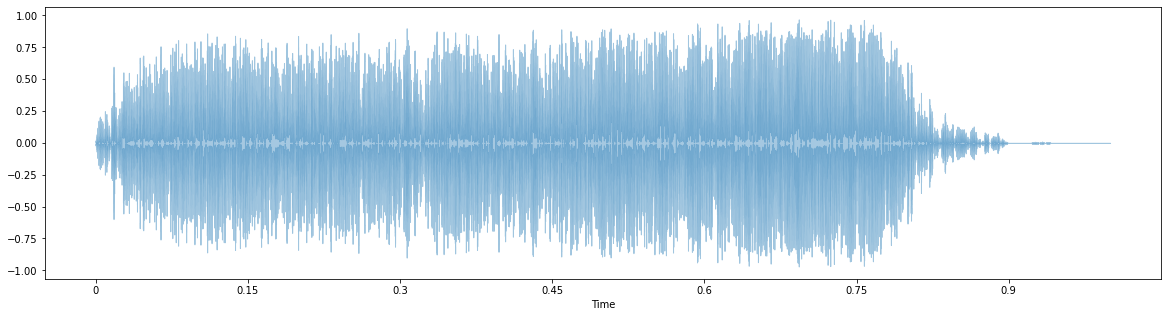

In [19]:
#@title Interpolación { run: "auto" }
audio_id = 'fm1' #@param {type:"string"}
audio_id2 = 'fm2' #@param {type:"string"}

porcentaje_de_cambio = 6 #@param {type:"slider", min:1, max:10, step:1}
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(5)

idx = list(DATA_filt[DATA_filt['id'] == audio_id].index)[0]
idx2 = list(DATA_filt[DATA_filt['id'] == audio_id2].index)[0]
audio_a = all_tracks_latent[0][idx]
audio_b = all_tracks_latent[0][idx2]
inter = latent_inter(audio_a, audio_b, 10, porcentaje_de_cambio)

#a_1 = latent_search(audio)[0]
#a_2 = latent_search(audio)[0]

#inter = latent_inter(a_1,a_2, 100, porcentaje_de_cambio)
#ax.plot(inter)
librosa.display.waveshow(inter, sr=16000, alpha=0.4, label='Original')
IPython.display.display(IPython.display.Audio(inter, rate = sr16k))



******
*
*
*
*
*
*
*
*
*
*
*
*




******

******
*
*
*
*
*
*
*
*
*
*
*
*




******

******
*
*
*
*
*
*
*
*
*
*
*
*




******

In [ ]:
#@title Descarga de materiales
!zip -r /content/model_vae.zip /content/model_vae

modelo = True #@param {type:"boolean"}
espacio_latente = True #@param {type:"boolean"}
boolean_checkbox = True #@param {type:"boolean"}

if modelo == True:
  files.download('/content/model_vae.zip')

'am_4.wav'